### Observations of Snow from space - Snow phenology

##### What does this notebook do?
Building on from the notebook Snow Monitoring using Landsat, this notebook looks at snow phenology - investigating patterns in the seasonal/cyclic nature of snow in the NSW Alpine region.
<br>
In this notebook:
<br>
We identify snow over a given region using Normalised Difference Snow Index (NDSI), along with Normalised Difference Vegetation Index (NDVI) where pixels defined as either snow or not snow, based on NDSI/NDVI thresholds. 
To investigate snow phenology, we look specifically at pixels above a given elevation. The proportion of pixels above the elevation classified as snow v. total number of valid pixels (above the given elevation) are then plotted against days of the year. 
 


In [1]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import os

sys.path.append('../10_Scripts')
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

In [2]:
# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')

User input:
In the following cell, we select the region of interest (commented out are 2 other snow regions of interest in Australia). As it is useful to look at snow phenology over a number of years (to assess any change), the time range given is for this decade.

The NDSI, NDVI thresholds can be altered based on results of snow mapping further down in this notebook.

In [3]:
# lat, lon, buffer_m, buffer_n = -36.86895, 147.276, 30000, 30000 #vic
# lat, lon, buffer_m, buffer_n = -41.56728, 147.67106, 10000, 10000 #tas ben lomond
lat, lon, buffer_m, buffer_n = -36.48, 148.26, 5200, 5200 #nsw
time_range = ('2010-01-01', '2018-12-31')

resolution = (-25, 25)

landsat_goodquality_prop = 0.3

# working out thresholds - geotiff for a number of different ones (methods for verification etc)
# fine tuned for different elevations.. 
#- trees change at different altidudes etc.. (depeding on region accurate thesholds can vary usually btwn 0.0-0.5)
ndsi_threshold = 0.2
ndvi_threshold = 0.3
#ndwi_threshold = 0.15
red_threshold = 1000

elev = 1800
elev1 = 1500

In [4]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}


In [7]:
DEAPlotting.display_map(y=query['y'], x=query['x'])

#### Loading data
Both ACCA and fmask cloudmasking products at times classify snow pixels as cloud - depending on the region/time range being investigated, the user may wish to adjust the snow cloudmask in the cell below. 

In [5]:
# snow_cloudmask can be altered to use either ACCA, fmask or both
snow_cloudmask = dict(    #cloud_acca='no_cloud',
                     cloud_fmask='no_cloud',
                     #cloud_shadow_acca='no_cloud_shadow',
                     cloud_shadow_fmask='no_cloud_shadow',
                     blue_saturated=False,
                     green_saturated=False,
                     red_saturated=False,
                     nir_saturated=False,
                     swir1_saturated=False,
                     swir2_saturated=False,
                     contiguous=True)

landsat_ds10s = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               mask_dict=snow_cloudmask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=False)

Loading ls8
    Loading 126 filtered ls8 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls5
    Loading 23 filtered ls5 timesteps
Combining and sorting ls8, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [6]:
# loading a true color image
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query, sensors=['ls8', 'ls7','ls5'], 
        bands_of_interest=['red', 'green', 'blue'], masked_prop=landsat_goodquality_prop, mask_pixel_quality=False, ls7_slc_off=False)

Loading ls8
    Loading 121 filtered ls8 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls5
    Loading 21 filtered ls5 timesteps
Combining and sorting ls8, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [7]:
valid_ds10s = np.isfinite(landsat_ds10s.swir1)

In [8]:
ndsi_ds10s = (landsat_ds10s.green - landsat_ds10s.swir1) / (landsat_ds10s.green + landsat_ds10s.swir1)
ndvi_ds10s = (landsat_ds10s.nir - landsat_ds10s.red) / (landsat_ds10s.nir + landsat_ds10s.red)

In [9]:
snow_ds_n = ndsi_ds10s > ndsi_threshold
noveg_ds10s = ndvi_ds10s < ndvi_threshold
red_ds10s = landsat_ds10s.red > 1000
snow_ds10s = noveg_ds10s & snow_ds_n & red_ds10s

Plot of snow/no-snow for given region - along side a true colour image. NDSI/NDVI threshold values can be adjusted in the user input nea the top of the notebook.

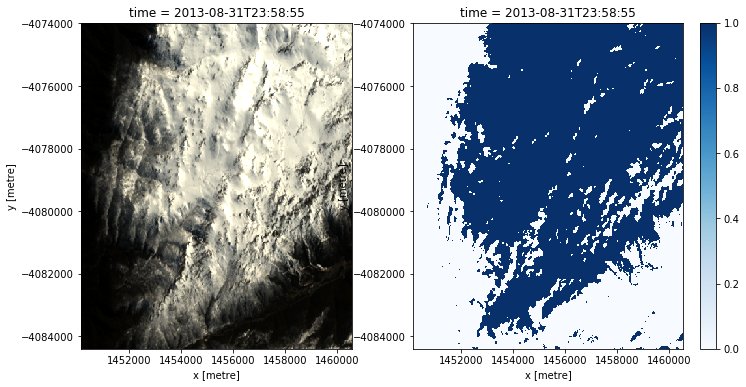

In [10]:
fig, axes = plt.subplots(ncols=2, figsize = (12, 6), gridspec_kw={'width_ratios': [4, 5]})
landsat_ds[['red', 'green', 'blue']].isel(time=28).to_array().plot.imshow(robust=True, ax=axes[0])
snow_ds10s.isel(time=31).plot(cmap='Blues', ax=axes[1])


#### Importing DEM - looking at snow pixels specifically above a given elevation

In [11]:
# Importing dem
# query region identical to the region being investigated, minus the time range
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query_dem = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query_dem)
dem_elev = dem_ds.dem > elev
dem_elev1 = dem_ds.dem > elev1

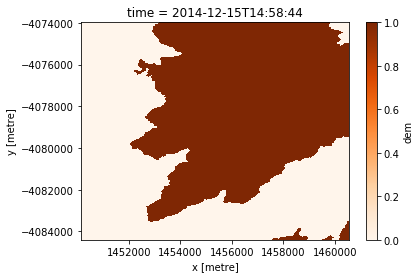

In [12]:
dem_elev.plot(cmap='Oranges')

Applying dem elevation as a mask over the region:

In [13]:
c=list(range(len(snow_ds10s.time)))
snow_prop_elev10s=[]
for i in c:
    d = valid_ds10s.isel(time=i).values * dem_elev
    f = snow_ds10s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev10s.append(snow)

In [14]:
snow_df10s = pd.DataFrame({'dayofyear':snow_ds10s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev10s, 'year':snow_ds10s['time.year']})

#### Creating DEM contours 
(from notebook Image Classification: Exracting contour lines)

In [15]:
elevation_2d = dem_ds.dem_h.squeeze('time')
contour_gdf_1800 = SpatialTools.contour_extract(z_values=1800,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1800.shp')


Operating in single array, multiple z-values mode
    Extracting contour 1800
Exporting contour shapefile to extracted_contours_1800.shp


To view the contour over a true color image:


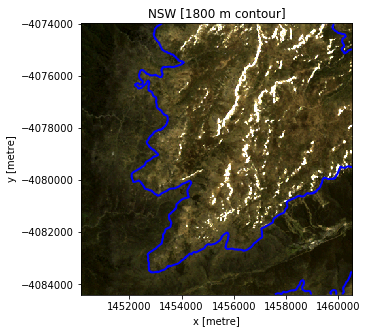

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
a=landsat_ds[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(robust=True, ax=ax)
a=contour_gdf_1800.plot(linewidth=2, color='blue', ax=ax)
# a=contour_gdf_1500.plot(linewidth=2, color='firebrick', ax=ax)
a.title.set_text('NSW [1800 m contour]')

### Plotting snow phenology
For pixels above the given elevation, number of pixels identified as snow / number of valid pixels, plotted against days of the year

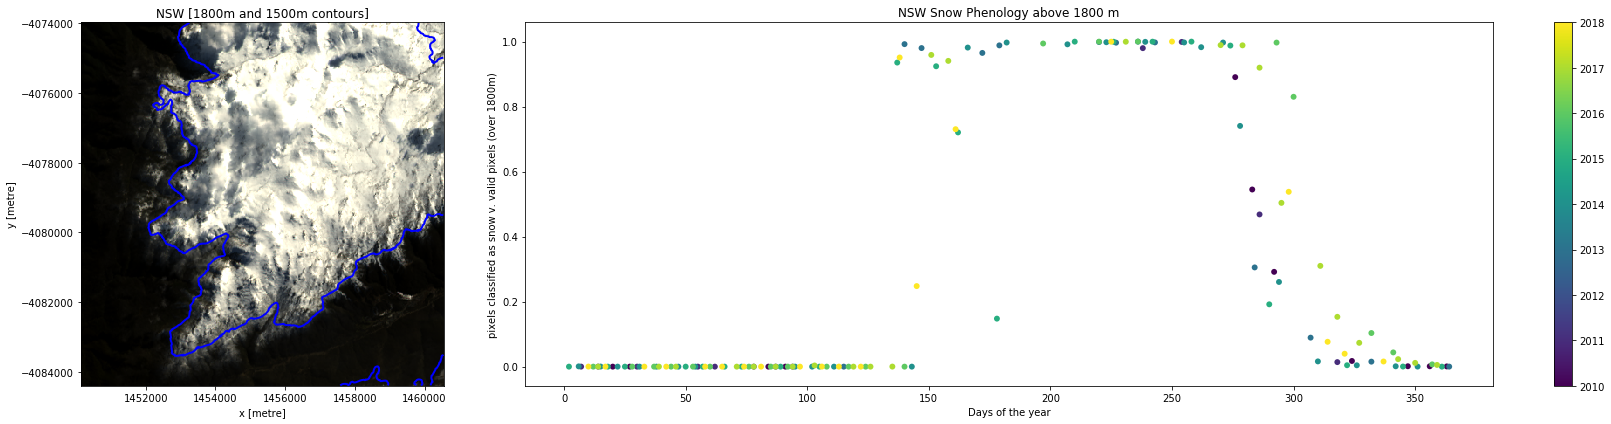

In [17]:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})
a=landsat_ds[['red', 'green', 'blue']].isel(time=23).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
a=contour_gdf_1800.plot(linewidth=2, color='blue',ax=axes[0])
# a=contour_gdf_1500.plot(linewidth=2, color='firebrick')
a.title.set_text('NSW [1800m and 1500m contours]')
plt.tight_layout()

sp = plt.scatter(snow_df10s['dayofyear'], #ndsi_ds.values, 
                snow_df10s['snow_prop_elev'], c=snow_df10s['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
plt.title('NSW Snow Phenology above 1800 m')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1800m)')
fig.colorbar(sp)
# pdf.savefig()
# fig.save('2010s_nsw_phenology.png')


#### This can be compared to phenology at other elevations:

In [18]:
# 1500 m elevation
contour_gdf_1500 = SpatialTools.contour_extract(z_values=1500, ds_array=elevation_2d, ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine, output_shp='extracted_contours_1500.shp')

c=list(range(len(snow_ds10s.time)))
snow_prop_elev10s_1500=[]
for i in c:
    d = valid_ds10s.isel(time=i).values * dem_elev1
    f = snow_ds10s.isel(time=i).values * dem_elev1
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev10s_1500.append(snow)
    
snow_df10s_1500 = pd.DataFrame({'dayofyear':snow_ds10s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev10s_1500, 'year':snow_ds10s['time.year']})

Operating in single array, multiple z-values mode
    Extracting contour 1500
Exporting contour shapefile to extracted_contours_1500.shp


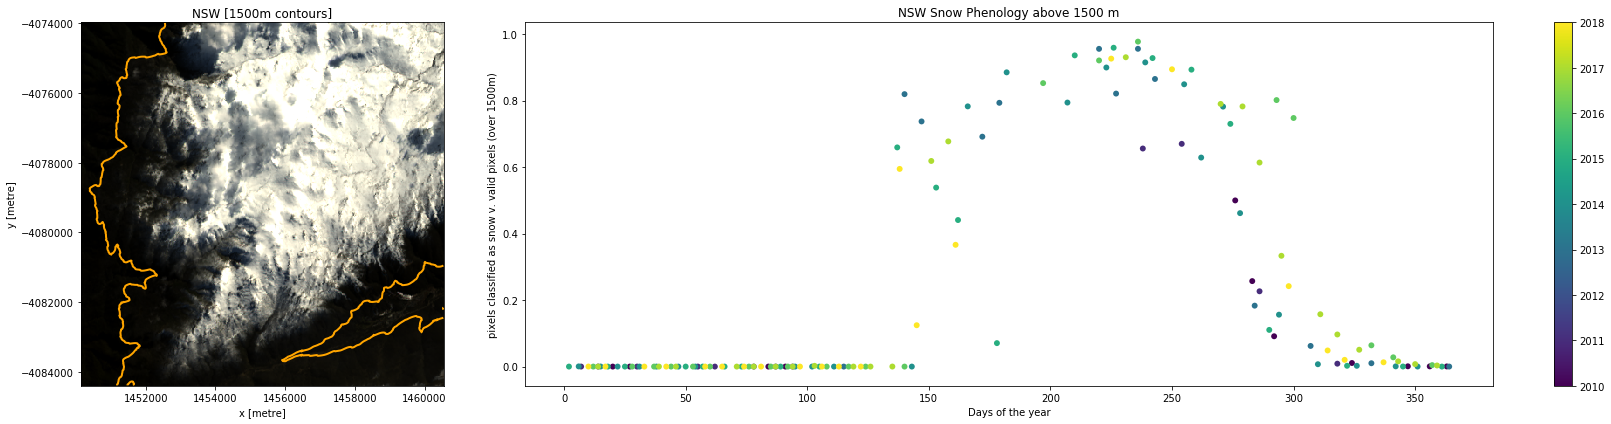

In [19]:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})
a=landsat_ds[['red', 'green', 'blue']].isel(time=23).to_array().plot.imshow(ax=axes[0],robust=True)
a=contour_gdf_1500.plot(linewidth=2, color='orange',ax=axes[0])
a.title.set_text('NSW [1500m contours]')
plt.tight_layout()
sp = plt.scatter(snow_df10s_1500['dayofyear'], snow_df10s_1500['snow_prop_elev'], c=snow_df10s_1500['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
plt.title('NSW Snow Phenology above 1500 m')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1500m)')
fig.colorbar(sp)

### Comparing snow phenology to previous decades:

In [20]:
time_range00s = ('2000-01-01', '2009-12-31')
time_range90s = ('1990-01-01', '1999-12-31')

In [21]:
query00s = {'x': (x - buffer_m, x + buffer_m), 'y': (y - buffer_n, y + buffer_n), 'time': time_range00s, 'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577', 'resolution': resolution}
query90s = {'x': (x - buffer_m, x + buffer_m), 'y': (y - buffer_n, y + buffer_n), 'time': time_range90s, 'crs': 'EPSG:3577',
            'output_crs': 'EPSG:3577', 'resolution': resolution}

In [22]:
landsat_ds00s = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query00s, mask_dict=snow_cloudmask, sensors=['ls8', 'ls7', 'ls5'],
            bands_of_interest=['red', 'green', 'blue','nir', 'swir1'], masked_prop=landsat_goodquality_prop, mask_pixel_quality=True, ls7_slc_off=False)

Loading ls8
    Skipping ls8; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 90 filtered ls7 timesteps
Loading ls5
    Loading 140 filtered ls5 timesteps
Combining and sorting ls7, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [23]:
landsat_ds90s = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query90s, mask_dict=snow_cloudmask, sensors=['ls8', 'ls7', 'ls5'],
            bands_of_interest=['red', 'green', 'blue','nir', 'swir1'], masked_prop=landsat_goodquality_prop, mask_pixel_quality=True, ls7_slc_off=False)

Loading ls8
    Skipping ls8; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 9 filtered ls7 timesteps
Loading ls5
    Loading 219 filtered ls5 timesteps
Combining and sorting ls7, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [24]:
# identifying valid pixels for prevoius decades over the imported region
valid_ds00s = np.isfinite(landsat_ds00s.swir1)
valid_ds90s = np.isfinite(landsat_ds90s.swir1)

In [25]:
# calculating NDSI for previous decades
ndsi_ds00s = (landsat_ds00s.green -landsat_ds00s.swir1) / (landsat_ds00s.green + landsat_ds00s.swir1)
ndvi_ds00s = (landsat_ds00s.nir - landsat_ds00s.red) / (landsat_ds00s.nir + landsat_ds00s.red)

ndsi_ds90s = (landsat_ds90s.green - landsat_ds90s.swir1) / (landsat_ds90s.green + landsat_ds90s.swir1)
ndvi_ds90s = (landsat_ds90s.nir - landsat_ds90s.red) / (landsat_ds90s.nir + landsat_ds90s.red)

In [26]:
# identifying snow pixels for previous decades over the given region
snow_ds0 = ndsi_ds00s > ndsi_threshold
noveg_ds00s = ndvi_ds00s < ndvi_threshold
red_ds00s = landsat_ds00s.red >1000
snow_ds00s = noveg_ds00s & snow_ds0 & red_ds00s

In [27]:
snow_ds9 = ndsi_ds90s > ndsi_threshold
noveg_ds90s = ndvi_ds90s < ndvi_threshold
red_ds90s = landsat_ds90s.red >1000
snow_ds90s = noveg_ds90s & snow_ds9 & red_ds90s

In [37]:
c=list(range(len(snow_ds00s.time)))
snow_prop_elev00s=[]
for i in c:
    d = valid_ds00s.isel(time=i).values * dem_elev
    f = snow_ds00s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev00s.append(snow)
    
c=list(range(len(snow_ds00s.time)))
snow_prop_elev00s_1500=[]
for i in c:
    d = valid_ds00s.isel(time=i).values * dem_elev1
    f = snow_ds00s.isel(time=i).values * dem_elev1
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev00s_1500.append(snow)

In [38]:
c=list(range(len(snow_ds90s.time)))
snow_prop_elev90s=[]
for i in c:
    d = valid_ds90s.isel(time=i).values * dem_elev
    f = snow_ds90s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev90s.append(snow)
    
    c=list(range(len(snow_ds90s.time)))
snow_prop_elev90s_1500=[]
for i in c:
    d = valid_ds90s.isel(time=i).values * dem_elev1
    f = snow_ds90s.isel(time=i).values * dem_elev1
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev90s_1500.append(snow)

In [39]:
snow_df00s = pd.DataFrame({'dayofyear':snow_ds00s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev00s, 'year':snow_ds00s['time.year']})
snow_df00s_1500 = pd.DataFrame({'dayofyear':snow_ds00s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev00s_1500, 'year':snow_ds00s['time.year']})
snow_df90s = pd.DataFrame({'dayofyear':snow_ds90s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev90s, 'year':snow_ds90s['time.year']})
snow_df90s_1500 = pd.DataFrame({'dayofyear':snow_ds90s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev90s_1500, 'year':snow_ds90s['time.year']})

In [36]:
# snow_df00s

### Comparing decades
Using rolling mean, the 3 decades are compared for each of the two elevations

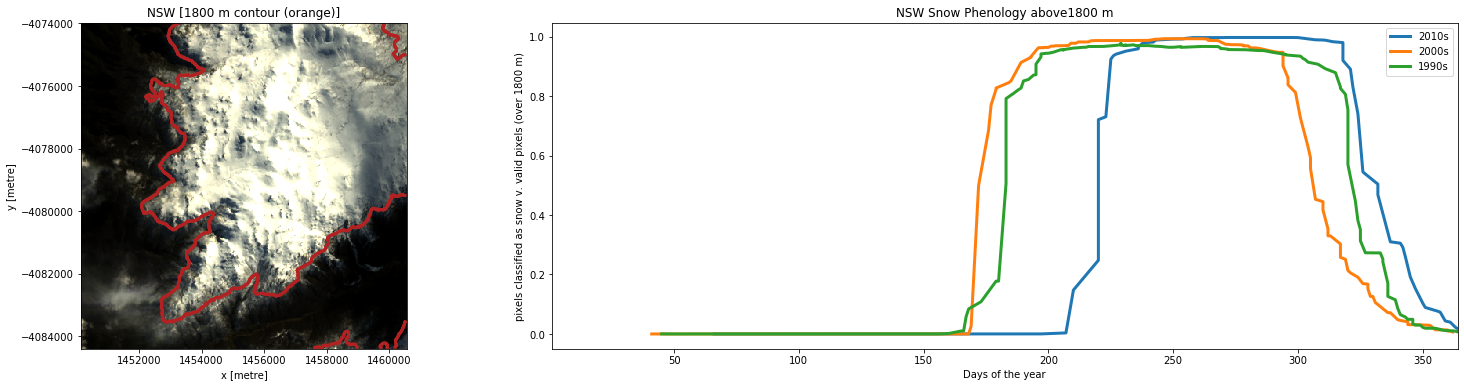

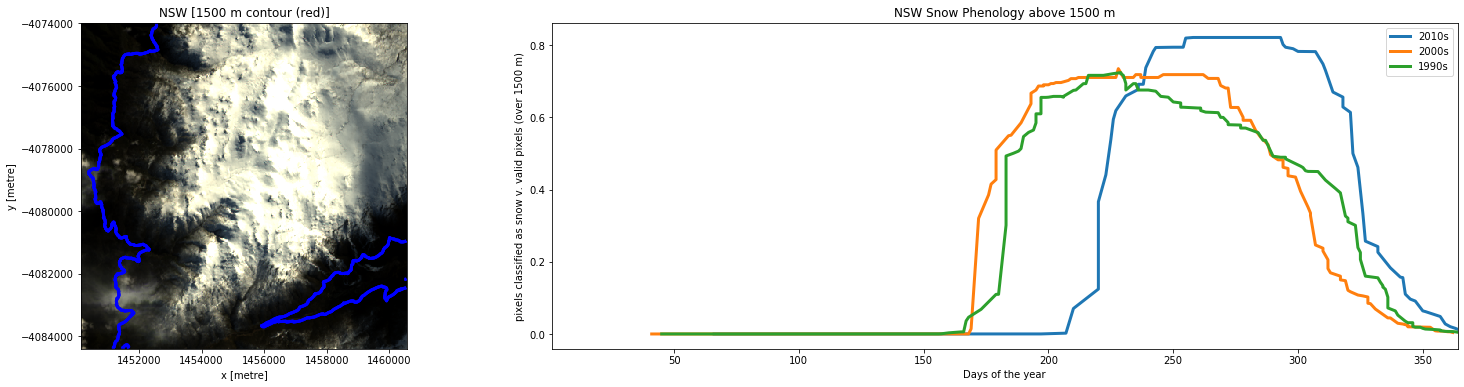

In [40]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW_dem_means_all.pdf")


dfs_1800=[ (snow_df10s, 1800, 3, 0, 'orange', 2010), (snow_df00s, 1800, 3, 0, 'orange', 2000), (snow_df90s, 1800, 3, 0, 'orange', 1990)]

dfs_1500=[ (snow_df10s_1500, 1500, 0, 3, 'red', 2010), (snow_df00s_1500, 1500, 0, 3, 'red', 2000), (snow_df90s_1500, 1500, 0, 3, 'red', 1990)]

fig, axes = plt.subplots(ncols=2, figsize = (25, 6), gridspec_kw={'width_ratios': [2, 5]})
for i, j, k, l, m, n in dfs_1800:
    a=landsat_ds[['red', 'green', 'blue']].isel(time=25).to_array().plot.imshow(ax=axes[0],robust=True)
    a=contour_gdf_1800.plot(ax=axes[0], linewidth=3, color='firebrick')
    a.title.set_text('NSW ['+str(j)+' m contour ('+str(m)+')]')
    b=i.set_index('dayofyear')
    c=b.sort_index(ascending=True)
    c.rolling(35).median().plot(y='snow_prop_elev', ax=axes[1], linewidth=3)
    plt.title('NSW Snow Phenology above'+str(j)+ ' m')
    plt.xlabel('Days of the year')
    plt.ylabel('pixels classified as snow v. valid pixels (over '+str(j)+' m)')
    plt.legend(['2010s', '2000s', '1990s'])
    pdf.savefig()

fig, axes = plt.subplots(ncols=2, figsize = (25, 6), gridspec_kw={'width_ratios': [2, 5]})
for i, j, k, l, m, n in dfs_1500:
    a=landsat_ds[['red', 'green', 'blue']].isel(time=25).to_array().plot.imshow(ax=axes[0],robust=True)
    a=contour_gdf_1500.plot(ax=axes[0], linewidth=3, color='blue')
    a.title.set_text('NSW ['+str(j)+' m contour ('+str(m)+')]')
    b=i.set_index('dayofyear')
    c=b.sort_index(ascending=True)
    c.rolling(35).median().plot(y='snow_prop_elev', ax=axes[1], linewidth=3)
    plt.title('NSW Snow Phenology above 1500 m')
    plt.xlabel('Days of the year')
    plt.ylabel('pixels classified as snow v. valid pixels (over 1500 m)')
    plt.legend(['2010s', '2000s', '1990s'])
    pdf.savefig()
pdf.close()

In [41]:
# from matplotlib.backends.backend_pdf import PdfPages
# import matplotlib.dates as mdates
# # import matplotlib.pyplot as plt
# # import matplotlib.backends.backend_pdf
# # pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW_dem_means_all.pdf")


# dfs_1800=[ (snow_df10s, 1800, 3, 0, 'orange', 2010), (snow_df00s, 1800, 3, 0, 'orange', 2000), (snow_df90s, 1800, 3, 0, 'orange', 1990)]

# dfs_1500=[ (snow_df10s_1500, 1500, 0, 3, 'red', 2010), (snow_df00s_1500, 1500, 0, 3, 'red', 2000), (snow_df90s_1500, 1500, 0, 3, 'red', 1990)]

# fig, axes = plt.subplots(ncols=2, figsize = (25, 6), gridspec_kw={'width_ratios': [2, 5]})
# for i, j, k, l, m, n in dfs_1800:
#     a=landsat_ds[['red', 'green', 'blue']].isel(time=25).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=3, color='firebrick')
#     a.title.set_text('NSW ['+str(j)+' m contour ('+str(m)+')]')
#     b=i.set_index('dayofyear')
#     c=b.sort_index(ascending=True)
#     c.rolling(35).median().plot(y='snow_prop_elev', ax=axes[1], linewidth=3)
#     plt.title('NSW Snow Phenology above'+str(j)+ ' m')
#     plt.xlabel('Days of the year')
#     plt.ylabel('pixels classified as snow v. valid pixels (over '+str(j)+' m)')
#     plt.legend(['2010s', '2000s', '1990s'])
# #     pdf.savefig()

# # fig, axes = plt.subplots(ncols=2, figsize = (25, 6), gridspec_kw={'width_ratios': [2, 5]})
# for i, j, k, l, m, n in dfs_1500:
#     a=landsat_ds[['red', 'green', 'blue']].isel(time=25).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1500.plot(ax=axes[0], linewidth=3, color='blue')
#     a.title.set_text('NSW ['+str(j)+' m contour ('+str(m)+')]')
#     b=i.set_index('dayofyear')
#     c=b.sort_index(ascending=True)
#     c.rolling(35).median().plot(y='snow_prop_elev', ax=axes[1], linewidth=3)
#     plt.title('NSW Snow Phenology above 1500 m')
#     plt.xlabel('Days of the year')
#     plt.ylabel('pixels classified as snow v. valid pixels (over 1500 m)')
#     plt.legend(['2010s', '2000s', '1990s'])
#     pdf.savefig()
# pdf.close()

In [1]:
# dfs=[
#     (snow_df10s, 1800, 3, 0, 'orange', 2010), 
#     (snow_df00s, 1800, 3, 0, 'orange', 2000),
#     (snow_df90s, 1800, 3, 0, 'orange', 1990),
#     (snow_df80s, 1800, 3, 0, 'orange', 1980),
#     (snow_df10s_1500, 1500, 0, 3, 'red', 2010), 
#     (snow_df00s_1500, 1500, 0, 3, 'red', 2000),
#     (snow_df90s_1500, 1500, 0, 3, 'red', 1990),
#     (snow_df80s_1500, 1500, 0, 3, 'red', 1980),
#     ]


# # below all fine ---
# for i, j, k, l, m, n in dfs:
#     fig, axes = plt.subplots(ncols=2, 
#                              figsize = (25, 6),
#                             gridspec_kw={'width_ratios': [2, 5]})

#     a=landsat_ds[['red', 'green', 'blue']].isel(time=25).to_array().plot.imshow(ax=axes[0],robust=True)
# #     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='orange')
#     a=contour_gdf_1500.plot(ax=axes[0], linewidth=l, color='firebrick')
#     a.title.set_text('NSW ['+str(j)+' m contour ('+str(m)+')]')
#     plt.tight_layout()

#     sp = plt.scatter(i['dayofyear'], #ndsi_ds.values, 
#                     i['snow_prop_elev'], c=i['year'],
#                     cmap='viridis', marker='o', edgecolor='none',s=35)
# #     plt.ylim(0,2)
#     plt.title('NSW Snow Phenology above '+str(j)+' m ('+str(n)+'s)')
#     plt.xlabel('Days of the year')
#     plt.ylabel('pixels classified as snow v. valid pixels (over '+str(j)+' m)')
#     fig.colorbar(sp)
#     pdf.savefig()
    
    
# fig, ax = plt.subplots(figsize=(16,5))  

Picking a cloud mask (ACCA or fmask)

In [138]:
# region:
# lat, lon, buffer_m, buffer_n = -41.56728, 147.67106, 10000, 10000 #tas ben lomond
lat, lon, buffer_m, buffer_n = -36.48, 148.26, 5200, 5200 #nsw

In [139]:
# time range:
time_range = ('2015-01-01', '2015-12-31')

In [161]:
landsat_goodquality_prop = 0.3

ndsi_threshold = 0.2
ndvi_threshold = 0.3
ndwi_threshold = 0.15

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

print('loading landsat_ds')
snow_mask = dict(cloud_acca='no_cloud',
                 #cloud_fmask='no_cloud',
                 cloud_shadow_acca='no_cloud_shadow',
                 #cloud_shadow_fmask='no_cloud_shadow',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True)
landsat_ds_a = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query, mask_dict=snow_mask, sensors=['ls5','ls7','ls8'],
                bands_of_interest=['red', 'green', 'nir','swir1'], masked_prop=landsat_goodquality_prop, mask_pixel_quality=True, ls7_slc_off=True)

loading landsat_ds
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 20 filtered ls7 timesteps
Loading ls8
    Loading 29 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [160]:
snow_mask2 = dict(
    #cloud_acca='no_cloud',
                 cloud_fmask='no_cloud',
#                  cloud_shadow_acca='no_cloud_shadow',
                 cloud_shadow_fmask='no_cloud_shadow',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True)
landsat_ds_f = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query, mask_dict=snow_mask2, sensors=['ls5','ls7','ls8'],
                bands_of_interest=['red', 'green', 'nir','swir1'], masked_prop=landsat_goodquality_prop, mask_pixel_quality=True, ls7_slc_off=True)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 21 filtered ls7 timesteps
Loading ls8
    Loading 22 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [162]:
snow_mask3 = dict(
    cloud_acca='no_cloud',
                 cloud_fmask='no_cloud',
                 cloud_shadow_acca='no_cloud_shadow',
                 cloud_shadow_fmask='no_cloud_shadow',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True)
landsat_ds_d = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query, mask_dict=snow_mask3, sensors=['ls5','ls7','ls8'],
                bands_of_interest=['red', 'green', 'nir','swir1'], masked_prop=landsat_goodquality_prop, mask_pixel_quality=True, ls7_slc_off=True)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 20 filtered ls7 timesteps
Loading ls8
    Loading 22 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [166]:
ndsi_ds_a = (landsat_ds_a.green - landsat_ds_a.swir1) / (landsat_ds_a.green + landsat_ds_a.swir1)
ndsi_ds_f = (landsat_ds_f.green - landsat_ds_f.swir1) / (landsat_ds_f.green + landsat_ds_f.swir1)
ndsi_ds_d = (landsat_ds_d.green - landsat_ds_d.swir1) / (landsat_ds_d.green + landsat_ds_d.swir1)

valid_ds_a = np.isfinite(landsat_ds_a.swir1)
valid_ds_f = np.isfinite(landsat_ds_f.swir1)
valid_ds_d = np.isfinite(landsat_ds_d.swir1)
snow_ds_a = ndsi_ds_a > ndsi_threshold
snow_ds_f = ndsi_ds_f > ndsi_threshold
snow_ds_d = ndsi_ds_d > ndsi_threshold


In [170]:
# if wanting to check above a particular elevation
elev=1800

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         #'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 
# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query1)
dem_elev = dem_ds.dem > elev

c=list(range(len(snow_ds_a.time)))
snow_prop_elev_a=[]
for i in c:
    d = valid_ds_a.isel(time=i).values * dem_elev
    f = snow_ds_a.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev_a.append(snow)
    
c=list(range(len(snow_ds_f.time)))
snow_prop_elev_f=[]
for i in c:
    d = valid_ds_f.isel(time=i).values * dem_elev
    f = snow_ds_f.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev_f.append(snow)

c=list(range(len(snow_ds_d.time)))
snow_prop_elev_d=[]
for i in c:
    d = valid_ds_d.isel(time=i).values * dem_elev
    f = snow_ds_d.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev_d.append(snow)


In [175]:
prop_a=[]
prop_rel_a=[]
c=list(range(len(snow_ds_a.time)))
for i in c:
    a=valid_ds_a.isel(time=i).values * dem_elev
    prop = np.count_nonzero(a.values) / np.count_nonzero(dem_elev.values)
    prop_a.append(prop)
    if snow_prop_elev_a[i] > 0.05:
        prop_rel_a.append(prop)
    else:
        prop_rel_a.append(np.nan)

import pandas as pd
df_a = pd.DataFrame({'time':snow_ds_a.time, 'snow_prop_elev':snow_prop_elev_a, 'pixel_prop':prop_a, 'pixel_over_005':prop_rel_a})

prop_f=[]
prop_rel_f=[]
c=list(range(len(snow_ds_f.time)))
for i in c:
    a=valid_ds_f.isel(time=i).values * dem_elev
    prop = np.count_nonzero(a.values) / np.count_nonzero(dem_elev.values)
    prop_f.append(prop)
    if snow_prop_elev_f[i] > 0.05:
        prop_rel_f.append(prop)
    else:
        prop_rel_f.append(np.nan)

df_f = pd.DataFrame({'time':snow_ds_f.time, 'snow_prop_elev':snow_prop_elev_f, 'pixel_prop':prop_f, 'pixel_over_005':prop_rel_f})

prop_d=[]
prop_rel_d=[]
c=list(range(len(snow_ds_d.time)))
for i in c:
    a=valid_ds_d.isel(time=i).values * dem_elev
    prop = np.count_nonzero(a.values) / np.count_nonzero(dem_elev.values)
    prop_d.append(prop)
    if snow_prop_elev_d[i] > 0.05:
        prop_rel_d.append(prop)
    else:
        prop_rel_d.append(np.nan)

df_d = pd.DataFrame({'time':snow_ds_d.time, 'snow_prop_elev':snow_prop_elev_d, 'pixel_prop':prop_d, 'pixel_over_005':prop_rel_d})

In [176]:
df_a=df_a.set_index('time')
df_a.columns = ['snow_prop_a', 'pixel_prop_a', '1800_validpix_v_allpixels_a']
df_f=df_f.set_index('time')
df_f.columns = ['snow_prop_a', 'pixel_prop_a', '1800_validpix_v_allpixels_a']
df_d=df_d.set_index('time')
df_d.columns = ['snow_prop_a', 'pixel_prop_a', '1800_validpix_v_allpixels_a']

In [179]:
df_a['under_20%'] = np.where(df_a['1800_validpix_v_allpixels_a'] < 0.2, df_a['1800_validpix_v_allpixels_a'], np.nan)
df_a['over_60%'] = np.where(df_a['1800_validpix_v_allpixels_a'] > 0.6, df_a['1800_validpix_v_allpixels_a'], np.nan)
df_f['under_20%'] = np.where(df_f['1800_validpix_v_allpixels_a'] < 0.2, df_f['1800_validpix_v_allpixels_a'], np.nan)
df_f['over_60%'] = np.where(df_f['1800_validpix_v_allpixels_a'] > 0.6, df_f['1800_validpix_v_allpixels_a'], np.nan)
df_d['under_20%'] = np.where(df_d['1800_validpix_v_allpixels_a'] < 0.2, df_d['1800_validpix_v_allpixels_a'], np.nan)
df_d['over_60%'] = np.where(df_d['1800_validpix_v_allpixels_a'] > 0.6, df_d['1800_validpix_v_allpixels_a'], np.nan)


In [180]:
a2=df_a.loc[:,'under_20%'].count()
a6=df_a.loc[:,'over_60%'].count()
ar=df_a.loc[:,'1800_validpix_v_allpixels_a'].count() - (a2+a6)
aa=df_a.loc[:,'1800_validpix_v_allpixels_a'].count()

f2=df_f.loc[:,'under_20%'].count()
f6=df_f.loc[:,'over_60%'].count()
fr=df_f.loc[:,'1800_validpix_v_allpixels_a'].count() - (f2+f6)
fa=df_f.loc[:,'1800_validpix_v_allpixels_a'].count()

d2=df_d.loc[:,'under_20%'].count()
d6=df_d.loc[:,'over_60%'].count()
dr=df_d.loc[:,'1800_validpix_v_allpixels_a'].count() - (d2+d6)
da=df_d.loc[:,'1800_validpix_v_allpixels_a'].count()

In [181]:
pixels = pd.DataFrame(columns=['ACCA', 'fmask', 'default'])

In [184]:
data_norm = [['ACCA', a2/aa, ar/aa, a6/aa],['fmask', f2/fa, fr/fa, f6/fa],['default', d2/da, dr/da, d6/da]]
pixels_norm = pd.DataFrame(data_norm, columns = ['mask','under20', 'rest', 'over60'])
pixels_norm = pixels_norm.set_index('mask')

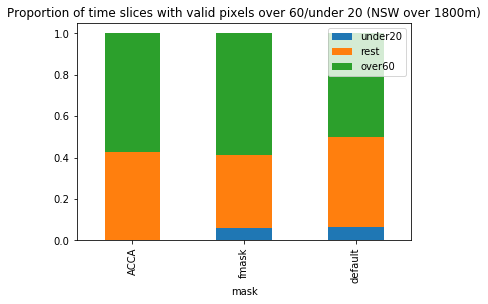

In [186]:
# fig, axes = plt.subplots(ncols=3, figsize = (20, 6))

pixels_norm.plot(kind='bar', stacked=True, 
                       #color=['firebrick', 'goldenrod', 'cadetblue'], 
                       title='Proportion of time slices with valid pixels over 60/under 20 (NSW over 1800m)')